In [1]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# Packages
from numpy import array, hstack
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, Flatten, TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.metrics import mean_squared_error
from math import sqrt

[*********************100%***********************]  1 of 1 completed


Text(0, 0.5, 'Prices ($)')

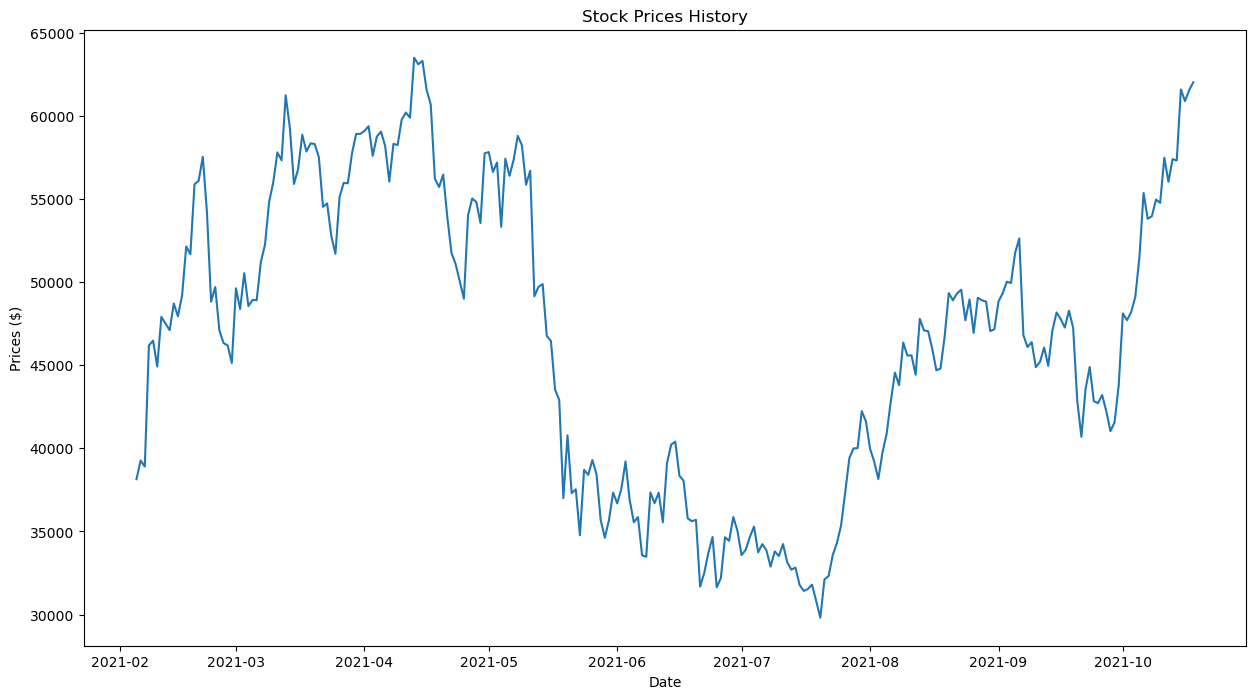

In [176]:
stock_data = yf.download('BTC-USD', start="2021-02-05", end="2021-10-19")

plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [4]:
stock_data.head(1)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359


## daily_score

In [175]:
daily_score = pd.read_csv('../data/time_serie_Twitter_sentiment.csv',index_col='Date')
daily_score.index = pd.to_datetime(daily_score.index)
daily_score

,Unnamed: 0,weighted_positive_score,weighted_neutral_score,weighted_negative_score,total,is_missing_value
Date,,,,,,
2021-02-05,0,0.299347,0.602728,0.097925,7705495.0,0
2021-02-06,1,0.358841,0.565735,0.075424,16580043.0,0
2021-02-07,2,0.378946,0.395909,0.225145,12031397.0,0
2021-02-08,3,0.509324,0.390879,0.099797,48100078.0,0
2021-02-09,4,0.571424,0.277535,0.151041,31872015.0,0
...,...,...,...,...,...,...
2021-10-15,252,0.290828,0.450175,0.237421,72051515.5,1
2021-10-16,253,0.290828,0.450175,0.237421,72051515.5,1
2021-10-17,254,0.290828,0.450175,0.237421,72051515.5,1


In [177]:
# Split Function
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix > len(sequences):
            break
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [178]:
def mape(y, y_hat):
    return np.mean(np.abs((y - y_hat)/y)*100)

In [8]:
sequences = data = pd.DataFrame({'log_return_open':[2**i for i in range(1,5)],
                     'log_return_close':[3**i for i in range(1,5)],
                     'log_volume':[5**i for i in range(1,5)] })
sequences

,log_return_open,log_return_close,log_volume
0,2,3,5
1,4,9,25
2,8,27,125
3,16,81,625


In [9]:
n_steps = 3
n_seq = 2
n_features = int((len(sequences.columns)-1)/2)
X,y= split_sequences(np.array(sequences), n_steps)

X

array([[[ 2,  3],
        [ 4,  9],
        [ 8, 27]],

       [[ 4,  9],
        [ 8, 27],
        [16, 81]]], dtype=int64)

In [142]:
def reverse(log_return,initial_value):
    return np.exp(np.cumsum(log_return))*initial_value

# CNN LSTM

In [210]:
log_return_open = np.diff(np.log(stock_data['Open']))
log_return_close = np.diff(np.log(stock_data['Close']))
log_volume = np.log(stock_data['Volume'])

# Prepare the data

data = pd.DataFrame({'log_return_open t-1':log_return_open,
                     'log_volume t-1':log_volume[:-1],
                     'log_return_close t-1' : log_return_close,
                     
                     'log_return_close t':log_return_close})


data['log_return_open t-1'] = data['log_return_open t-1'].shift(1)
data['log_return_close t-1'] = data['log_return_close t-1'].shift(1)
data['log_volume t-1'] = data['log_volume t-1'].shift(1)
data = data[1:]
dataset = np.array(data)
dataset = dataset.reshape((len(dataset), len(data.columns)))

In [211]:
data

,log_return_open t-1,log_volume t-1,log_return_close t-1,log_return_close t
Date,,,,
2021-02-06,0.032155,24.793968,0.028983,-0.009277
2021-02-07,0.028735,24.990527,-0.009277,0.171821
2021-02-08,-0.009301,24.905326,0.171821,0.006143
2021-02-09,0.171999,25.343002,0.006143,-0.034203
2021-02-10,0.006147,25.242985,-0.034203,0.064468
...,...,...,...,...
2021-10-13,-0.026217,24.438879,0.023979,-0.001387
2021-10-14,0.023536,24.453389,-0.001387,0.071887
2021-10-15,-0.000469,24.323745,0.071887,-0.011459


In [212]:
# Set parameters
n_steps = 3
n_seq = 1
n_features = int((len(data.columns)-1))

# Define Model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
# 3 - Forecast
end_training_day = 30
y_actual = dataset[end_training_day:,len(data.columns)-1:] # Real values for accuracy measurement
finalresults=pd.DataFrame()

# Increasing window cross-validation 
for k in range (10):
    result=pd.DataFrame()
    for w in range(end_training_day, len(dataset), 7):
        train=dataset[:w]
        X, y = split_sequences(train, n_steps)
        X = X.reshape((X.shape[0], n_seq, n_steps, n_features))
        model.fit(X, y, epochs=200, verbose=0)
        
        test_X,y_test=split_sequences(dataset[w-n_steps+1:w+7],n_steps)
        if y_test[0]!=dataset[w,len(data.columns)-1:][0]:
            break
    
        for test_i in test_X:
            aaa = test_i.reshape((1, n_seq, n_steps, n_features))
            yhat = pd.DataFrame(model.predict(aaa, verbose=0))
            result=pd.concat((result, yhat))
    finalresults=pd.concat((finalresults, result), axis=1)

y_mean=pd.DataFrame(finalresults.mean(axis=1))
print(sqrt(mean_squared_error(y_actual, y_mean)))
print(mape(y_actual,y_mean))

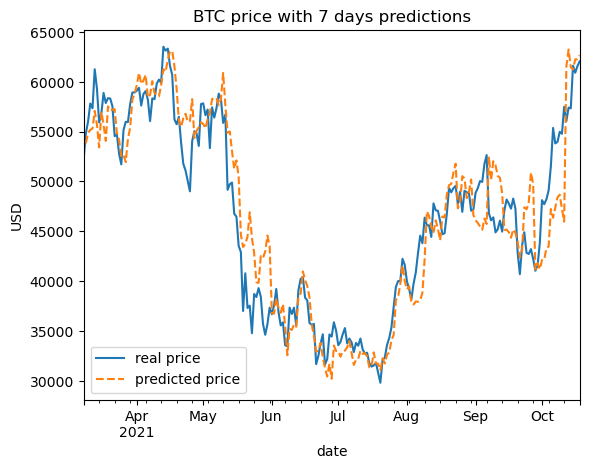

In [209]:
real_price = stock_data['Close'][end_training_day+1:].values

t_price = np.array([])
for w in range(0,len(y_mean), 7):
    t_price = np.concatenate([t_price,reverse(y_mean.values.flatten()[w:w+7], real_price[w])])
    
stock_data['Close'][end_training_day+1:].plot(label='real price')

pd.Series(t_price, index=stock_data['Close'][end_training_day+2:].index).plot(label='predicted price',linestyle='dashed')
    
# plt.plot(real_price)
# plt.plot(t_price,label='predicted price',linestyle='dashed')
plt.legend()
plt.xlabel('date')
plt.ylabel('USD')
plt.title('BTC price with 7 days predictions')
plt.savefig('btc prediction without sentiment variables.png',dpi=500)

# CNN LSTM sentimental

In [184]:
log_return_open = np.diff(np.log(stock_data['Open']))
log_return_close = np.diff(np.log(stock_data['Close']))
postive_score = daily_score['weighted_positive_score'].values
negative_score = daily_score['weighted_negative_score'].values
log_volume = np.log(stock_data['Volume'])

# Prepare the data

data = pd.DataFrame({'log_return_open t-1':log_return_open,
                     'log_volume t-1':log_volume[:-1],
                     'log_return_close t-1' : log_return_close,
                     'positive_score': postive_score[:-2],
                     'negative_score': negative_score[:-2],
                     'log_return_close t':log_return_close})


data['log_return_open t-1'] = data['log_return_open t-1'].shift(1)
data['log_return_close t-1'] = data['log_return_close t-1'].shift(1)
data['log_volume t-1'] = data['log_volume t-1'].shift(1)

data['positive_score'] = data['positive_score']
data['negative_score'] = data['negative_score']



data = data[1:]
dataset = np.array(data)
dataset = dataset.reshape((len(dataset), len(data.columns)))

In [185]:
# Set parameters
n_steps = 5
n_seq = 1
n_features = int((len(data.columns)-1))

# Define Model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [186]:
# 3 - Forecast
end_training_day = 30
y_actual = dataset[end_training_day:,len(data.columns)-1:] # Real values for accuracy measurement
finalresults=pd.DataFrame()

# Increasing window cross-validation 
for k in range (10):
    result=pd.DataFrame()
    for w in range(end_training_day, len(dataset), 7):
        train=dataset[:w]
        X, y = split_sequences(train, n_steps)
        X = X.reshape((X.shape[0], n_seq, n_steps, n_features))
        model.fit(X, y, epochs=200, verbose=0)
        
        test_X,y_test=split_sequences(dataset[w-n_steps+1:w+7],n_steps)
        if y_test[0]!=dataset[w,len(data.columns)-1:][0]:
            break
    
        for test_i in test_X:
            aaa = test_i.reshape((1, n_seq, n_steps, n_features))
            yhat = pd.DataFrame(model.predict(aaa, verbose=0))
            result=pd.concat((result, yhat))
    finalresults=pd.concat((finalresults, result), axis=1)

y_mean_sent=pd.DataFrame(finalresults.mean(axis=1))
print(sqrt(mean_squared_error(y_actual, y_mean_sent)))
print(mape(y_actual,y_mean_sent))

0.03946474520825696
0    303.191184
dtype: float64


D:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


## Visualisation

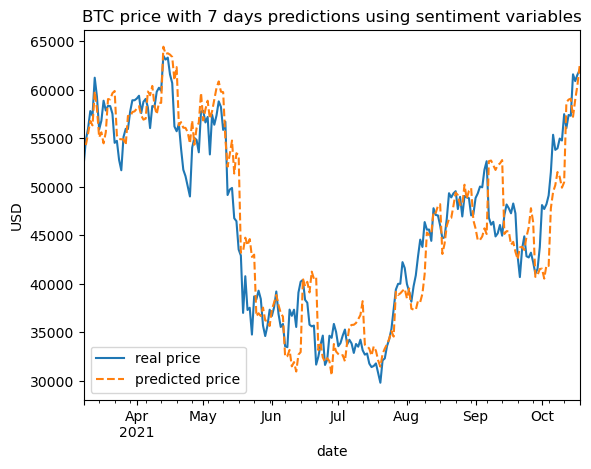

In [203]:
t_price = np.array([])
for w in range(0,len(y_mean), 7):
    t_price = np.concatenate([t_price,reverse(y_mean.values.flatten()[w:w+7], real_price[w])])
    
t_price_sent = np.array([])
for w in range(0,len(y_mean_sent), 7):
    t_price_sent = np.concatenate([t_price_sent,reverse(y_mean_sent.values.flatten()[w:w+7], real_price[w])])
    
stock_data['Close'][end_training_day+1:].plot(label='real price')

pd.Series(t_price, index=stock_data['Close'][end_training_day+2:].index).plot(label='forecasted price',linestyle='dashed')

pd.Series(t_price_sent, index=stock_data['Close'][end_training_day+2:].index).plot(label='forecasted price using sentiment variables',linestyle='dashed')
    
# plt.plot(real_price)
# plt.plot(t_price,label='predicted price',linestyle='dashed')
plt.legend()
plt.xlabel('date')
plt.ylabel('USD')
plt.title('7 days forecast of BTC ')
plt.savefig('btc prediction with sentiment variables and without.png',dpi=500)

## Bilstm

In [68]:
# Set parameters
n_steps = 1
n_features = len(data.columns)-1

# Define BiLSTM Model
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [69]:
# 3 - Forecast
y_actual = dataset[60:,len(data.columns)-1:] # Real values for accuracy measurement
finalresults=pd.DataFrame()

# Increasing window cross-validation 
for k in range (2):
    result=pd.DataFrame()
    for w in range(60, len(dataset), 7):
        train=dataset[:w]
        X, y = split_sequences(train, n_steps)
        test=dataset[w:w+7,:len(data.columns)-1]
        model.fit(X, y, epochs=200, verbose=0)
    
        for test_i in test:
            aaa = test_i.reshape((1, n_steps, n_features))
            yhat = pd.DataFrame(model.predict(aaa, verbose=0))
            result=pd.concat((result, yhat))
    finalresults=pd.concat((finalresults, result), axis=1)

y_mean=pd.DataFrame(finalresults.mean(axis=1))
print(sqrt(mean_squared_error(y_actual, y_mean)))
print(mape(y_actual,y_mean))

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.